#### Import necessery packages

In [3]:
import numpy as np
from PIL import Image
import random
import cv2
import os
import matplotlib.pyplot as plt

#### LSB Modification

1


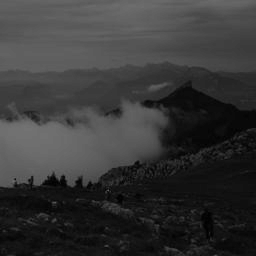

In [1]:
from PIL import Image

def set_lsb(pixel_value, lsb_bit):
    cleared_pixel_value = pixel_value & 0b1111111111111110
    # Set the LSB to the desired value
    modified_pixel_value = cleared_pixel_value | lsb_bit
    return modified_pixel_value

def manipulate_image_lsb(input_image_path, output_image_path, lsb_value=0):
    print(lsb_value)
    original_image = Image.open(input_image_path)
    image_data = list(original_image.getdata())
    manipulated_data = [set_lsb(pixel_value, lsb_value) for pixel_value in image_data]
    manipulated_image = Image.new(original_image.mode, original_image.size)
    manipulated_image.putdata(manipulated_data)
    manipulated_image.save(output_image_path)

    return manipulated_image
manipulate_image_lsb(r'C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\COVER\2.png', 'output1.png', lsb_value=1) # lsb_value = 0 or 1 


##### Apply LSB modification to bunch of images 

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image


def MODIFY_img_LSB(input_folder, output_folder):
    all_files = os.listdir(input_folder)
    all_files.sort(key=lambda x: int(os.path.splitext(x)[0].split("_")[0]))
    MODIFIED_LSB = 1
    for filename in all_files:
        file_path = os.path.join(input_folder, filename)
        org_filename = os.path.splitext(filename)[0]     

        MLSB_filename = f"{org_filename}__LSB{MODIFIED_LSB}.png" 
        output_path = os.path.join(output_folder, MLSB_filename)
        
        manipulate_image_lsb(file_path, output_path, MODIFIED_LSB)

    print("Completed")


if __name__ == "__main__":

    # input_folder = "NOISE"  
    input_folder = "COVER"  
    output_folder = "BIT_MNIPULATED" 
    MODIFY_img_LSB(input_folder,output_folder)

#### Generate rectangles with noise 

In [3]:
def generate_all_combinations(x_values, y_values):
    combinations = [(y, x) for y in y_values for x in x_values]
    return combinations

def Add_White_Noise(image, x, y):
    corners = generate_all_combinations(x, y)
    noise_radius = np.random.randint(0, 3)
    selected_corner = random.choice(corners)
    image_array = np.array(image)
    noise_y, noise_x = np.ogrid[-noise_radius:noise_radius + 1, -noise_radius:noise_radius + 1]
    noise_mask = noise_x**2 + noise_y**2 <= noise_radius**2
    noise_y = np.clip(noise_y + selected_corner[0], 0, 255)
    noise_x = np.clip(noise_x + selected_corner[1], 0, 255)

    try:
        image_array[noise_y, noise_x] = 255
    except IndexError:
        pass
    
    return Image.fromarray(image_array)

def Add_Black_Noise(image, x, y):
    outside_corners = generate_all_combinations(x, y)
    outside_selected_corner = random.choice(outside_corners)
    
    image_array = np.array(image)
    
    noise_radius = np.random.randint(0, 4)
    noise_y, noise_x = np.ogrid[-noise_radius:noise_radius + 1, -noise_radius:noise_radius + 1]
    noise_mask = noise_x**2 + noise_y**2 <= noise_radius**2
    noise_y = np.clip(noise_y + outside_selected_corner[0], 0, 255)
    noise_x = np.clip(noise_x + outside_selected_corner[1], 0, 255)
    
    try:
        image_array[noise_y, noise_x] = 0
    except IndexError:
        pass
    
    return Image.fromarray(image_array)

def add_white_noise(image,top_left_y,bottom_right_y, top_left_x,bottom_right_x):
    num_clusters = np.random.randint(0,5)  # Choose 1 to 2 clusters
    image = np.array(image)
    for _ in range(num_clusters):
        cluster_size = np.random.randint(0, 4)  # Cluster size: 2 to 4 pixels
        cluster_x = np.random.randint(top_left_x, bottom_right_x - cluster_size + 1)
        cluster_y = np.random.randint(top_left_y, bottom_right_y - cluster_size + 1)
        cluster_values = np.random.choice([0, 255], size=(cluster_size, cluster_size))
        image[cluster_y:cluster_y+cluster_size, cluster_x:cluster_x+cluster_size] = cluster_values

    return image

def add_black_noise(image):
    height, width = image.shape
    num_clusters = np.random.randint(0,30)
    for _ in range(num_clusters):
        cluster_size = np.random.randint(0, 4) 
        cluster_x = np.random.randint(0, width - cluster_size + 1)
        cluster_y = np.random.randint(0, height - cluster_size + 1)
        image[cluster_y:cluster_y+cluster_size, cluster_x:cluster_x+cluster_size] = 0

def Add_Round_Corner(image,top_left_y,bottom_right_y, top_left_x,bottom_right_x):
    radius = random.randint(4,10)  
    round_corner = np.random.choice(['top_left', 'top_right', 'bottom_left', 'bottom_right'])
    if round_corner == 'top_left':
        mask = np.zeros_like(image)
        cv2.circle(mask, (top_left_x + radius, top_left_y + radius), radius, 255, thickness=-1)
        image = np.maximum(image, mask)
    elif round_corner == 'top_right':
        mask = np.zeros_like(image)
        cv2.circle(mask, (bottom_right_x - radius, top_left_y + radius), radius, 255, thickness=-1)
        image = np.maximum(image, mask)
    elif round_corner == 'bottom_left':
        mask = np.zeros_like(image)
        cv2.circle(mask, (top_left_x + radius, bottom_right_y - radius), radius, 255, thickness=-1)
        image = np.maximum(image, mask)
    elif round_corner == 'bottom_right':
        mask = np.zeros_like(image)
        cv2.circle(mask, (bottom_right_x - radius, bottom_right_y - radius), radius, 255, thickness=-1)
        image = np.maximum(image, mask)


def Gen_Rects(image, min_size=12, max_size=16, noise_radius=2, ):
    top_left_x, top_left_y = np.random.randint(6, 200, 2)
    max_width = min(max_size, 256 - top_left_x)
    max_height = min(max_size, 256 - top_left_y)
    width = np.random.randint(min_size, max_width + 1)
    height = np.random.randint(min_size, max_height + 1)
    bottom_right_x = top_left_x + width
    bottom_right_y = top_left_y + height
    x = (top_left_x,top_left_x-1,top_left_x+1, bottom_right_x , bottom_right_x - 1, bottom_right_x + 1)
    y = (top_left_y,top_left_y-1,top_left_y+1, bottom_right_y , bottom_right_y - 1, bottom_right_y + 1)
    image[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 0

    call_function_randomly = random.choice([True,False])
    if call_function_randomly:
        image = add_white_noise(image,top_left_y,bottom_right_y, top_left_x,bottom_right_x)


    call_function_randomly = random.choice([True,False])
    if call_function_randomly:
        image = Add_White_Noise(image,x,y)

    call_function_randomly = random.choice([True,False])
    if call_function_randomly:
        image = Add_Black_Noise(image,x,y)

    return image


def GEN_MUL_Rects(num_rectangles,ORG_name):
    image_size=(256, 256)
    rectangles = []
    for i in range(num_rectangles):
        matrix = np.ones(image_size, dtype=np.uint8) * 255
        matrix = Gen_Rects(matrix, min_size=12, max_size=16)
        rectangles.append(np.array(matrix))
        add_black_noise(rectangles[i])
        
    for i, rect in enumerate(rectangles):
        image = Image.fromarray(rect)
        image.save(f"{ORG_name}__Rects{i + 1}.png")
    return rectangles




#### Encoder function

In [7]:

def overlap_and_save_images(rectangles, image_size=(256, 256)):
    final_matrix = np.ones(image_size, dtype=np.uint8) * 255
    for rectangle_matrix in rectangles:
        final_matrix[rectangle_matrix == 0] = 0
    final_image = Image.fromarray(final_matrix)
    return np.array(final_image)


# Encoder 
def Encode_rectangle(image_path, payload):
    original_image = Image.open(image_path)
    secret_array = payload
    original_array = np.array(original_image)
    #-------------- MAIN ENCODER------------------------ 
    if len(secret_array.shape) == 3:
        secret_array = np.mean(secret_array, axis=-1)
        
    for y in range(secret_array.shape[0]):
        for x in range(secret_array.shape[1]):
            original_pixel = original_array[y, x]
            secret_pixel = secret_array[y, x]
            modified_pixel = (original_pixel & 0b1111111111111110) | (secret_pixel & 1)
            original_array[y, x] = modified_pixel

    steganographic_image = Image.fromarray(original_array)
  
    return steganographic_image

#### Apply encoding on bunch of images

In [9]:

def HIDE_images(input_folder, Rects_folder, Stego_folder, Stego_folder2):
    all_files = os.listdir(input_folder)
    all_files.sort(key=lambda x: int(os.path.splitext(x)[0].split("_")[0]))

    for filename in all_files:
        file_path = os.path.join(input_folder, filename)
        org_filename = os.path.splitext(filename)[0]     
        print("Working on :", file_path)
        Rects_output_path = os.path.join(Rects_folder, org_filename)
        gen_rects = 3
        rects = GEN_MUL_Rects(gen_rects,Rects_output_path)
        ovrRects = overlap_and_save_images(rects)
        for i in range(5):
            if i < gen_rects:
                encoded_image = Encode_rectangle(file_path,rects[i])
                stego_filename = f"{org_filename}__Rect{i}.png"
                output_path = os.path.join(Stego_folder, stego_filename)
            else :
                encoded_image = Encode_rectangle(file_path,ovrRects)
                stego_filename = f"{org_filename}__OVR_Rect.png" 
                output_path = os.path.join(Stego_folder2, stego_filename)
                
            encoded_image_array = np.array(encoded_image)
            cv2.imwrite(output_path, encoded_image_array )

    print("Completed")


if __name__ == "__main__":

    # input_folder = "TEST"  
    input_folder = r"C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED"  
    Rects = r"C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Rects"
    Stego_folder = r"C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect" 
    Stego_folder2 = r"C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect_OVERLAP"
    HIDE_images(input_folder,Rects, Stego_folder, Stego_folder2)
    

Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\1__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\2__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\3__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\4__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\5__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\6__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\7__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\8__LSB1.png
Working on : C:\Users\shova\OneDrive\Desktop\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\B

#### Plot output

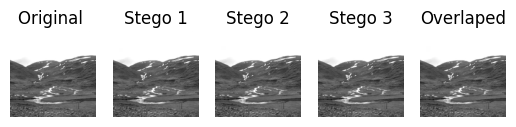

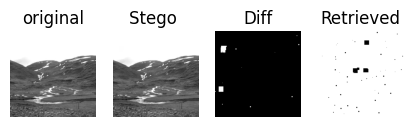

In [62]:
img = np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\BIT_MNIPULATED\1__LSB1.png").convert("L"))

image0= np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect\1__LSB1__Rect0.png").convert("L"))
image1= np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect\1__LSB1__Rect1.png").convert("L"))
image2= np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect\1__LSB1__Rect2.png").convert("L"))
image3= np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect_OVERLAP\1__LSB1__OVR_Rect.png").convert("L"))

image4 = np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\extracted_rectangle.png").convert("L"))

plt.subplot(1, 5, 1 )
plt.imshow(img, cmap='gray')
plt.title('Original ')
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(image0, cmap='gray')
plt.title('Stego 1')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(image1, cmap='gray')
plt.title('Stego 2')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(image2, cmap='gray')
plt.title('Stego 3')
plt.axis('off')
plt.subplot(1, 5, 5 )
plt.imshow(image3, cmap='gray')
plt.title('Overlaped')
plt.axis('off')

plt.show()


plt.subplot(2, 5, 1)
plt.imshow(img, cmap='gray')
plt.title('original')
plt.axis('off')
plt.subplot(2, 5, 2)
plt.imshow(image3, cmap='gray')
plt.title('Stego ')
plt.axis('off')
r = img - image3
plt.subplot(2, 5, 3)
plt.imshow(r, cmap='gray')
plt.title('Diff')
plt.axis('off')
s = image4
plt.subplot(2, 5, 4 )
plt.imshow(s, cmap='gray')
plt.title('Retrieved')
plt.axis('off')
plt.show()


#### Decoder Function

In [117]:
def decode_rectangle(steganographic_image_path, output_image_path):
    steganographic_image = Image.open(steganographic_image_path)
    steganographic_array = np.array(steganographic_image)
    extracted_rectangle = steganographic_array & 1
    # extracted_image = Image.fromarray((extracted_rectangle * 255).astype(np.uint8))
    extracted_image = Image.fromarray((extracted_rectangle*255).astype(np.uint8))
    extracted_image.save(output_image_path)

    
decode_rectangle(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect_OVERLAP\1__LSB1__OVR_Rect.png", "extracted_rectangle.png")


### Single Filter | (10X10 grid, 25X25 pixels ) 

##### Break Image -> Decode breaked Images -> Merge Decoded Images

##### 1> Break Image and store in a Folder 

In [160]:
from PIL import Image
import numpy as np

def break_image_to_grid(image_path, output_folder):
    original_image = Image.open(image_path)
    original_array = np.array(original_image)
    cell_size = (25, 25)
    grid_size = (10, 10)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Break the image into a 10x10 grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            cell = original_array[i * cell_size[0]: (i + 1) * cell_size[0],
                                   j * cell_size[1]: (j + 1) * cell_size[1]]

            cell_image = Image.fromarray(cell.astype(np.uint8))
            cell_image.save(os.path.join(output_folder, f'cell_{i}_{j}.png'))

# Example usage
input_image_path = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect_OVERLAP\1__LSB1__OVR_Rect.png'  # Replace with the path to your input image
output_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Output_Folder'  # Replace with the desired output folder

break_image_to_grid(input_image_path, output_folder)


##### 2> Display breaked Images 

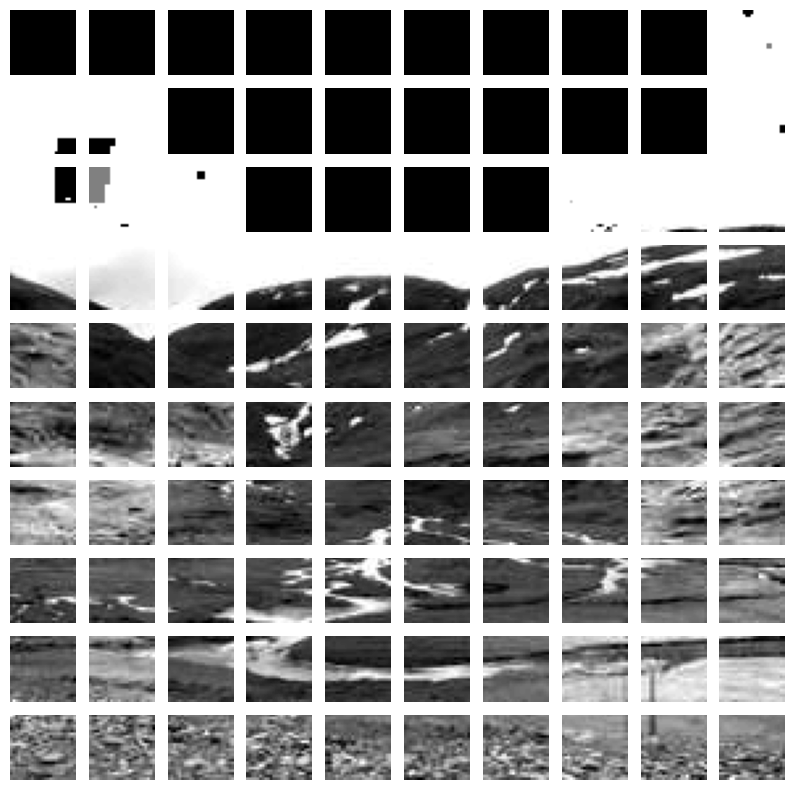

In [164]:
import os
import matplotlib.pyplot as plt

def show_cells(output_folder):
    files = os.listdir(output_folder)
    files.sort()

    # Create a subplot for each cell
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))

    for i in range(10):
        for j in range(10):
            file_path = os.path.join(output_folder, f'cell_{i}_{j}.png')
            # file_path = os.path.join(output_folder, f'decoded_{i}_{j}.png')
            cell_image = plt.imread(file_path)

            # Display the cell
            axes[i, j].imshow(cell_image, cmap='gray')
            axes[i, j].axis('off')

    plt.show()

# Example usage
output_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Output_Folder'  # Replace with the actual output folder name
show_cells(output_folder)


##### 3> Decode breaked Images 

In [1]:
def Threshold_Rects(img_array):
    row, col = img_array.shape
    b, w, T = 0, 0, 0
    for i in range(row):
        for j in range(col):
            T += 1
            if img_array[i][j] == 0:
                b += 1
            elif img_array[i][j] == 255:
                w += 1

    black_percentage = b / T
    if black_percentage <= 0.1:
        img_array[:, :] = 255
        return img_array
    else:
        return img_array

def decode_rectangle(steganographic_image_path, output_image_path):
    steganographic_image = Image.open(steganographic_image_path)
    steganographic_array = np.array(steganographic_image)
    extracted_rectangle = steganographic_array & 1
    extracted_image = Image.fromarray((extracted_rectangle * 255).astype(np.uint8))
    extracted_array = np.array(extracted_image)
    extracted_array = Threshold_Rects(extracted_array)
    
    final_image = Image.fromarray(extracted_array)
    final_image.save(output_image_path)

def decode_rectangles(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all cell images in the input folder
    for i in range(10):
        for j in range(10):
            file_path = os.path.join(input_folder, f'cell_{i}_{j}.png')
            output_path = os.path.join(output_folder, f'decoded_{i}_{j}.png')

            # Apply the decode_rectangle function to the cell image
            decode_rectangle(file_path, output_path)

# Example usage
input_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Output_Folder'  # Replace with the actual output folder name
output_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_cells'  # Replace with the desired output folder name
decode_rectangles(input_folder, output_folder)

NameError: name 'os' is not defined

##### 4> Merge Decoded breaked Images 

In [156]:
import os
import numpy as np
from PIL import Image

def merge_cells(input_folder, original_size=(256, 256), cell_size=(25, 25)):
    # Initialize the original image with all white pixels
    original_image = np.ones(original_size, dtype=np.uint8) * 255

    # Iterate over all cells and merge them into the original image
    for i in range(10):
        for j in range(10):
            file_path = os.path.join(input_folder, f'decoded_{i}_{j}.png')
            cell_image = np.array(Image.open(file_path))

            # Calculate the coordinates for merging
            start_row = i * cell_size[0]
            start_col = j * cell_size[1]
            end_row = (i + 1) * cell_size[0]
            end_col = (j + 1) * cell_size[1]

            # Merge the cell into the original image
            original_image[start_row:end_row, start_col:end_col] = cell_image

    return original_image

# Example usage
input_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_cells'  # Replace with the actual output folder name
output_path = 'merged_image.png'  # Replace with the desired output path
result_image = merge_cells(input_folder)

# Save the merged image
Image.fromarray(result_image).save(output_path)


##### Check Outputs 

(-0.5, 255.5, 255.5, -0.5)

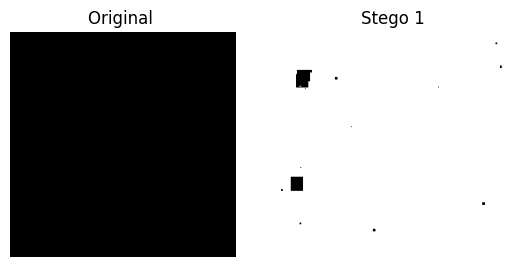

In [166]:
image1= np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Output_Folder\cell_0_3.png").convert("L"))
image2= np.asarray(Image.open(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\merged_image.png").convert("L"))

plt.subplot(1, 2, 1 )
plt.imshow(image1, cmap='gray')
plt.title('Original ')
plt.axis('off')
plt.subplot(1,2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Stego 1')
plt.axis('off')

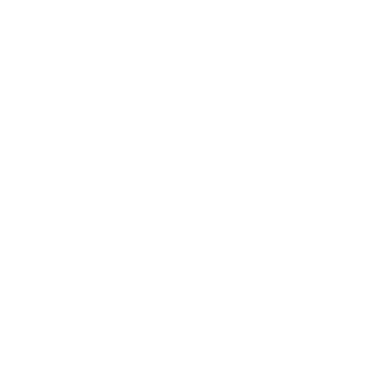

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create an image with each pixel value set to 200
gray_image = np.ones((256, 256), dtype=np.uint8) * 255

# Display the image
plt.imshow(gray_image, cmap='gray_r')
plt.axis('off')
plt.show()


### Multiple Filter 

##### 1> Break Images Into different grids 

In [1]:
import os
from PIL import Image
import numpy as np

def break_image_to_dynamic_grid(image_path, output_folder, ratios):
    original_image = Image.open(image_path)
    original_array = np.array(original_image)
    rows, cols = original_array.shape[:2]

    for ratio in ratios:
        height_ratio, width_ratio = ratio
        min_size = min(rows, cols)
        max_size = min(20, min_size)  # Ensure max size is within the specified range

        # Calculate dynamic cell size based on the specified ratio
        cell_height = np.random.randint(6, max_size)
        cell_width = int(cell_height * width_ratio / height_ratio)

        # Ensure cell size is within the image bounds
        if cell_height >= rows or cell_width >= cols:
            continue

        # Calculate the number of rows and columns for the dynamic grid
        num_rows = int(rows / cell_height)
        num_cols = int(cols / cell_width)

        # Ensure the output folder exists
        output_folder_path = os.path.join(output_folder, f'Ratio_{height_ratio}_{width_ratio}')
        os.makedirs(output_folder_path, exist_ok=True)

        # Break the image into a dynamic grid
        for i in range(num_rows):
            for j in range(num_cols):
                cell = original_array[i * cell_height: (i + 1) * cell_height,
                                       j * cell_width: (j + 1) * cell_width]

                cell_image = Image.fromarray(cell.astype(np.uint8))
                cell_image.save(os.path.join(output_folder_path, f'cell_{i}_{j}.png'))

# Example usage
input_image_path = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\STEGO_Rect_OVERLAP\1__LSB1__OVR_Rect.png'  # Replace with the path to your input image
output_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Breaked_Images'  # Replace with the desired output folder
ratios = [
    (1, 2),
    (2, 1),
    (1, 1),
    (3, 1),
    (1, 3)
]

break_image_to_dynamic_grid(input_image_path, output_folder, ratios)


##### 2> Display breaked Images 

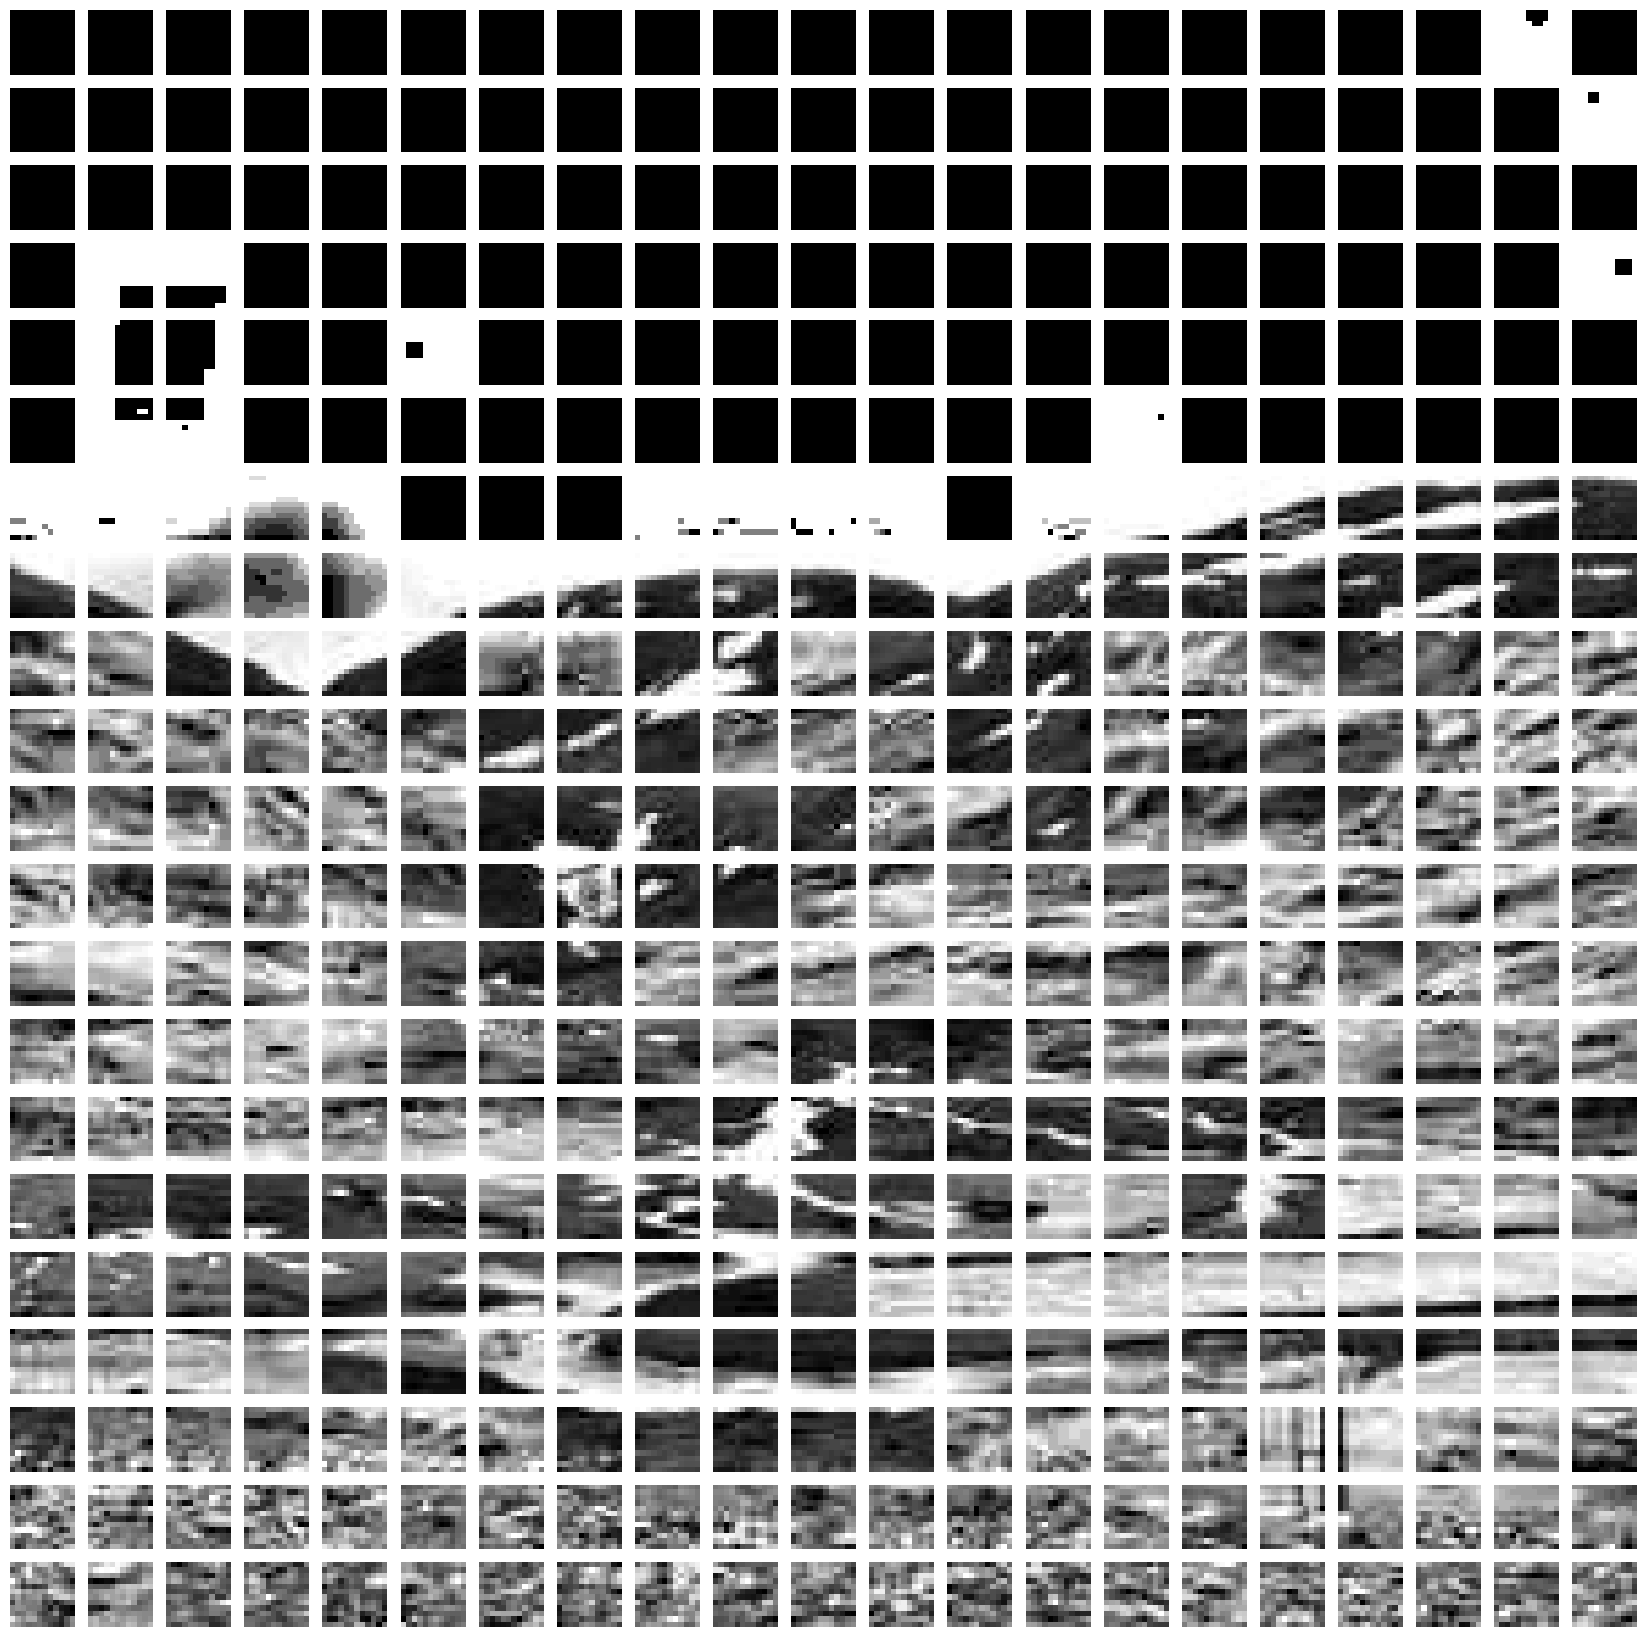

In [1]:
import os
import matplotlib.pyplot as plt
import math

def calculate_grid_and_cell_size(output_folder):
    # Get the list of image files in the output folder
    image_files = [f for f in os.listdir(output_folder) if f.endswith('.png')]

    if not image_files:
        raise ValueError("No image files found in the output folder.")

    # Assuming the image files are named in the format 'cell_i_j.png'
    i_values = [int(file.split('_')[1]) for file in image_files]
    j_values = [int(file.split('_')[2].split('.')[0]) for file in image_files]

    # Calculate the grid size and cell size based on the maximum i and j values
    max_i = max(i_values)
    max_j = max(j_values)
    grid_size = (max_i + 1, max_j + 1)

    # Assuming the images are square, so we use the first image to get the cell size
    first_image_path = os.path.join(output_folder, image_files[0])
    first_image = plt.imread(first_image_path)
    cell_size = first_image.shape[:2]

    return grid_size, cell_size

def show_cells_dynamically(output_folder):
    # Calculate the grid size and cell size
    grid_size, cell_size = calculate_grid_and_cell_size(output_folder)

    # Create a subplot for each cell
    fig, axes = plt.subplots(*grid_size, figsize=(grid_size[1], grid_size[0]))

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            file_path = os.path.join(output_folder, f'cell_{i}_{j}.png')
            cell_image = plt.imread(file_path)

            # Display the cell
            axes[i, j].imshow(cell_image, cmap='gray')
            axes[i, j].axis('off')

    plt.show()

# Example usage
output_folder_dynamic = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\2_ Multiple Filter\Breaked_Images\Ratio_1_1'
show_cells_dynamically(output_folder_dynamic)


##### 2.1> Merge Breaked Images Without Padding  

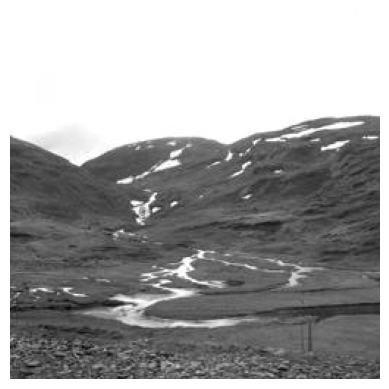

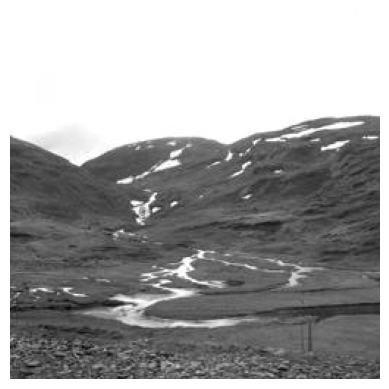

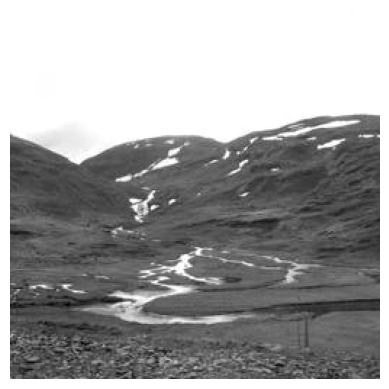

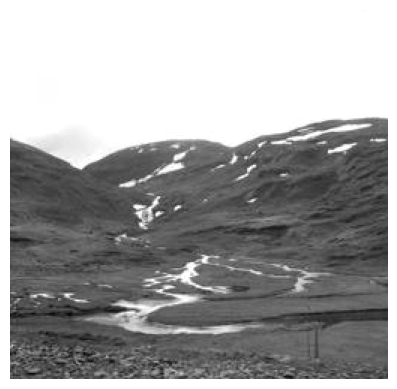

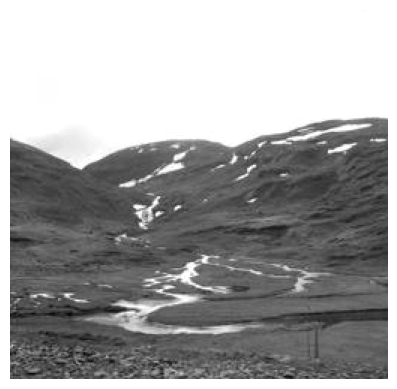

In [5]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def calculate_grid_and_cell_size(input_folder):
    # Get the list of image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    if not image_files:
        raise ValueError("No image files found in the input folder.")

    # Assuming the image files are named in the format 'cell_i_j.png'
    i_values = [int(file.split('_')[1]) for file in image_files]
    j_values = [int(file.split('_')[2].split('.')[0]) for file in image_files]

    # Calculate the grid size and cell size based on the maximum i and j values
    max_i = max(i_values)
    max_j = max(j_values)
    grid_size = (max_i + 1, max_j + 1)

    # Assuming the images are square, so we use the first image to get the cell size
    first_image_path = os.path.join(input_folder, image_files[0])
    first_image = np.array(Image.open(first_image_path))
    cell_size = first_image.shape[:2]

    return grid_size, cell_size

def merge_cells_dynamic(input_folder):
    # Calculate the grid size and cell size
    grid_size, cell_size = calculate_grid_and_cell_size(input_folder)

    # Initialize the original image with all white pixels
    original_image = np.ones((grid_size[0] * cell_size[0], grid_size[1] * cell_size[1]), dtype=np.uint8) * 255

    # Iterate over all cells and merge them into the original image
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            file_path = os.path.join(input_folder, f'cell_{i}_{j}.png')
            cell_image = np.array(Image.open(file_path))

            # Calculate the coordinates for merging
            start_row = i * cell_size[0]
            start_col = j * cell_size[1]
            end_row = (i + 1) * cell_size[0]
            end_col = (j + 1) * cell_size[1]

            # Merge the cell into the original image
            original_image[start_row:end_row, start_col:end_col] = cell_image

    return original_image

# Example usage
input_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Breaked_Images'
Folders = ['Ratio_1_1','Ratio_1_2','Ratio_1_3','Ratio_2_1','Ratio_3_1',]
for folder in Folders:
    input_folder_dynamic= os.path.join(input_folder, folder)
    result_image_dynamic = merge_cells_dynamic(input_folder_dynamic)
    l = len(input_folder_dynamic)
    i = input_folder_dynamic[l-1]
    j = input_folder_dynamic[l-3]
    output_path_dynamic = f'merged_image_{i}{j}.png'
    Image.fromarray(result_image_dynamic).save(output_path_dynamic)
    plt.imshow(result_image_dynamic, cmap='gray')
    plt.axis('off')
    plt.show()


##### 2.2> Merge Breaked Images With Padding  

In [14]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def calculate_grid_and_cell_size(input_folder):
    # Get the list of image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    if not image_files:
        raise ValueError("No image files found in the input folder.")

    # Assuming the image files are named in the format 'cell_i_j.png'
    i_values = [int(file.split('_')[1]) for file in image_files]
    j_values = [int(file.split('_')[2].split('.')[0]) for file in image_files]

    # Calculate the grid size and cell size based on the maximum i and j values
    max_i = max(i_values)
    max_j = max(j_values)
    grid_size = (max_i + 1, max_j + 1)

    # Assuming the images are square, so we use the first image to get the cell size
    first_image_path = os.path.join(input_folder, image_files[0])
    first_image = np.array(Image.open(first_image_path))
    cell_size = first_image.shape[:2]

    return grid_size, cell_size

def merge_cells_dynamic(input_folder, original_size=(256, 256)):
    # Calculate the grid size and cell size
    grid_size, cell_size = calculate_grid_and_cell_size(input_folder)

    # Initialize the original image with all white pixels
    original_image = np.ones((grid_size[0] * cell_size[0], grid_size[1] * cell_size[1]), dtype=np.uint8) * 255

    # Iterate over all cells and merge them into the original image
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            file_path = os.path.join(input_folder, f'cell_{i}_{j}.png')
            cell_image = np.array(Image.open(file_path))

            # Calculate the coordinates for merging
            start_row = i * cell_size[0]
            start_col = j * cell_size[1]
            end_row = (i + 1) * cell_size[0]
            end_col = (j + 1) * cell_size[1]

            # Merge the cell into the original image
            original_image[start_row:end_row, start_col:end_col] = cell_image

    # Add padding if the resulting shape is different from the original size
    pad_rows = original_size[0] - original_image.shape[0]
    pad_cols = original_size[1] - original_image.shape[1]

    if pad_rows > 0 or pad_cols > 0:
        original_image = np.pad(original_image, ((0, pad_rows), (0, pad_cols)), mode='constant', constant_values=255)

    return original_image

# Example usage
input_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Breaked_Images'
output_path_dynamic = 'merged_image_'  # Replace with the desired output path

Folders = ['Ratio_1_1','Ratio_1_2','Ratio_1_3','Ratio_2_1','Ratio_3_1']
for folder in Folders:
    input_folder_dynamic = os.path.join(input_folder, folder)
    result_image_dynamic = merge_cells_dynamic(input_folder_dynamic)
    l = len(input_folder_dynamic)
    i = input_folder_dynamic[l-1]
    j = input_folder_dynamic[l-3]
    output_path_dynamic = f'Padded\Merged_Image_Padded_{i}{j}.png'
    Image.fromarray(result_image_dynamic).save(output_path_dynamic)
    # plt.imshow(result_image_dynamic, cmap='gray')
    # plt.axis('off')
    # plt.show()


##### 3> Decode Breaked Images  

In [9]:
import os
import numpy as np
from PIL import Image

def Threshold_Rects(img_array):
    row, col = img_array.shape
    b, w, T = 0, 0, 0
    for i in range(row):
        for j in range(col):
            T += 1
            if img_array[i][j] == 0:
                b += 1
            elif img_array[i][j] == 255:
                w += 1

    black_percentage = b / T
    if black_percentage <= 0.1:
        img_array[:, :] = 255
        return img_array
    else:
        return img_array

def decode_rectangle(steganographic_image_path, output_image_path):
    steganographic_image = Image.open(steganographic_image_path)
    steganographic_array = np.array(steganographic_image)
    extracted_rectangle = steganographic_array & 1
    extracted_image = Image.fromarray((extracted_rectangle * 255).astype(np.uint8))
    extracted_array = np.array(extracted_image)
    extracted_array = Threshold_Rects(extracted_array)
    
    final_image = Image.fromarray(extracted_array)
    final_image.save(output_image_path)

def decode_rectangles_dynamic(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get the list of image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    if not image_files:
        raise ValueError("No image files found in the input folder.")

    # Assuming the image files are named in the format 'cell_i_j.png'
    i_values = [int(file.split('_')[1]) for file in image_files]
    j_values = [int(file.split('_')[2].split('.')[0]) for file in image_files]

    # Calculate the grid size based on the maximum i and j values
    max_i = max(i_values)
    max_j = max(j_values)
    grid_size = (max_i + 1, max_j + 1)

    # Iterate over all cell images in the input folder
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            file_path = os.path.join(input_folder, f'cell_{i}_{j}.png')
            output_path = os.path.join(output_folder, f'decoded_{i}_{j}.png')

            # Apply the decode_rectangle function to the cell image
            decode_rectangle(file_path, output_path)

# Example usage
input_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Breaked_Images'
output_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_Images'
Folders = ['Ratio_1_1','Ratio_1_2','Ratio_1_3','Ratio_2_1','Ratio_3_1']
for folder in Folders:
    input_folder_dynamic = os.path.join(input_folder, folder)
    result_image_dynamic = merge_cells_dynamic(input_folder_dynamic)
    output_folder_dynamic =  os.path.join(output_folder, folder)
    decode_rectangles_dynamic(input_folder_dynamic, output_folder_dynamic)


##### 4> Merge Decoded Breaked Images For Each types of Grids 

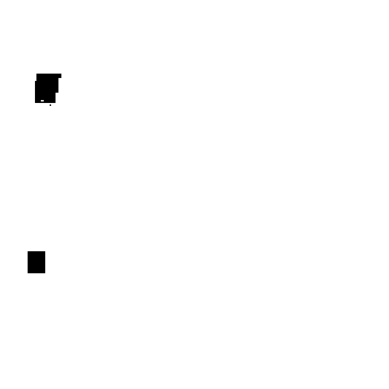

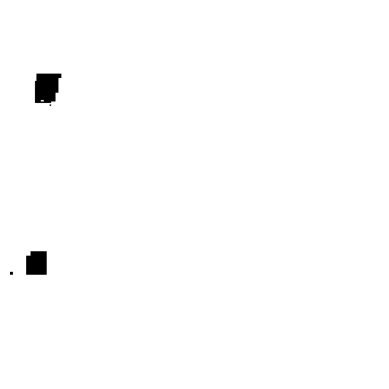

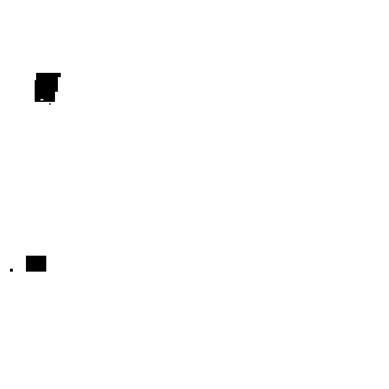

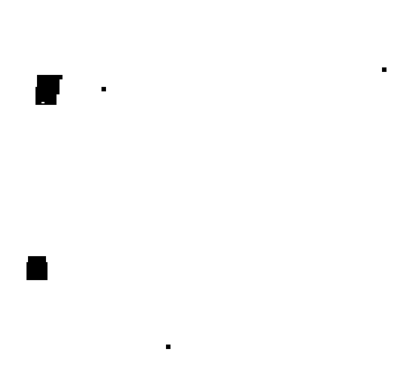

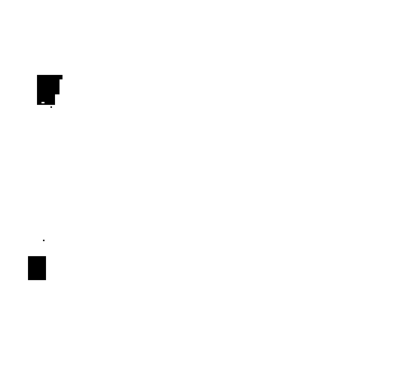

In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def calculate_grid_and_cell_size(input_folder):
    # Get the list of image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    if not image_files:
        raise ValueError("No image files found in the input folder.")

    # Assuming the image files are named in the format 'cell_i_j.png'
    i_values = [int(file.split('_')[1]) for file in image_files]
    j_values = [int(file.split('_')[2].split('.')[0]) for file in image_files]

    # Calculate the grid size and cell size based on the maximum i and j values
    max_i = max(i_values)
    max_j = max(j_values)
    grid_size = (max_i + 1, max_j + 1)

    # Assuming the images are square, so we use the first image to get the cell size
    first_image_path = os.path.join(input_folder, image_files[0])
    first_image = np.array(Image.open(first_image_path))
    cell_size = first_image.shape[:2]

    return grid_size, cell_size

def merge_cells_dynamic(input_folder):
    # Calculate the grid size and cell size
    grid_size, cell_size = calculate_grid_and_cell_size(input_folder)

    # Initialize the original image with all white pixels
    original_image = np.ones((grid_size[0] * cell_size[0], grid_size[1] * cell_size[1]), dtype=np.uint8) * 255

    # Iterate over all cells and merge them into the original image
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            file_path = os.path.join(input_folder, f'decoded_{i}_{j}.png')
            cell_image = np.array(Image.open(file_path))

            # Calculate the coordinates for merging
            start_row = i * cell_size[0]
            start_col = j * cell_size[1]
            end_row = (i + 1) * cell_size[0]
            end_col = (j + 1) * cell_size[1]

            # Merge the cell into the original image
            original_image[start_row:end_row, start_col:end_col] = cell_image

    return original_image

# Example usage
input_folder = r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_Images'
Folders = ['Ratio_1_1','Ratio_1_2','Ratio_1_3','Ratio_2_1','Ratio_3_1',]
for folder in Folders:
    input_folder_dynamic= os.path.join(input_folder, folder)
    result_image_dynamic = merge_cells_dynamic(input_folder_dynamic)
    l = len(input_folder_dynamic)
    i = input_folder_dynamic[l-1]
    j = input_folder_dynamic[l-3]
    output_path_dynamic = f'Decoded_merged_image_{i}{j}.png'
    Image.fromarray(result_image_dynamic).save(output_path_dynamic)
    plt.imshow(result_image_dynamic, cmap='gray')
    plt.axis('off')
    plt.show()


##### 5> Overlap All (5) Merged Decoded Images 

In [15]:
import numpy as np
from PIL import Image

def resize_and_pad_image(image_path, target_size=(256, 256), padding_color=255):
    original_image = Image.open(image_path)
    original_array = np.array(original_image)

    # Resize image to the target size
    resized_array = np.zeros(target_size, dtype=np.uint8)
    resized_array[:original_array.shape[0], :original_array.shape[1]] = original_array

    return resized_array

def overlap_images(image_paths, output_path, alpha=0.5):
    # Ensure all images have the same size
    target_size = (256, 256)
    image_arrays = [resize_and_pad_image(path, target_size) for path in image_paths]

    # Initialize the final image with the first image
    final_image = image_arrays[0].copy()

    # Overlay the remaining images
    for overlay_image in image_arrays[1:]:
        final_image = alpha * overlay_image + (1 - alpha) * final_image

    # Ensure values are within the valid range [0, 255]
    final_image = np.clip(final_image, 0, 255).astype(np.uint8)

    # Save or display the final overlapped image
    Image.fromarray(final_image, mode='L').save(output_path)


# Example usage
image_paths = [
    r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_merged_image_11.png',
    r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_merged_image_12.png',
    r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_merged_image_13.png',
    r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_merged_image_21.png',
    r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\Decoded_merged_image_31.png'
    # Add more image paths as needed
]

output_path = 'Decoded_overlapped_image.png'
overlap_images(image_paths, output_path)
